# Rigid Bodies

In [1]:
import foyer
import hoomd
from hoomd.data import make_snapshot
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import numpy as np
import matplotlib.pyplot as plt

from planckton.utils.rigid import connect_rings
import ex_render

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/mdtraj/core/trajectory.py:32: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Let's start with a simple case--a benzene molcule.

In [2]:
bz_str = "c1ccccc1"
bz = mb.load(bz_str, smiles=True, ignore_box_warn=True)
name = "bz"
bz.name = name
#bz.visualize().show()

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#npt_str = "c1ccc2ccccc2c1"
#npt = mb.load(npt_str, smiles=True, ignore_box_warn=True)
#npt.visualize().show()

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#py_str = "c1cc2cccc3ccc4cccc1c4c32"
#py = mb.load(py_str, smiles=True, ignore_box_warn=True)
#py.visualize().show()

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's try fixing the orientation of the benzene molecules when we fill the box--I think that might make it work better with rigid bodies.

In [5]:
box = mb.Box([5,5,5])
system = mb.fill_box(bz, n_compounds=10, box=box, fix_orientation=True)
#system.visualize().show()

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
gaff = foyer.forcefields.load_GAFF()
pmd_system = system.to_parmed(residues=[name])
typed_system = gaff.apply(system)
#print(set([atom.type for atom in typed_system.atoms]))

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/foyer/forcefield.py:449: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/foyer/forcefield.py:461: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart de


I'm using mbuild from [PR #808](https://github.com/mosdef-hub/mbuild/pull/808) which allows `create_hoomd_simulation` to read in a snapshot:

```
create_hoomd_simulation(structure, ref_distance=1.0, ref_mass=1.0, ref_energy=1.0, r_cut=1.2, auto_scale=False, snapshot_kwargs={}, pppm_kwargs={'Nx': 8, 'Ny': 8, 'Nz': 8, 'order': 4}, init_snap=None)
```

First, make a snapshot with 10 rigid particles--one for each benzene ring:

In [7]:
sim = hoomd.context.SimulationContext()

with sim:
    hoomd.context.initialize("")
    init_snap = make_snapshot(N=10, particle_types=["_R"], box=hoomd.data.boxdim(L=10))

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 10/17/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
with sim:
    hoomd_objects, ref_values = create_hoomd_simulation(
        typed_system, auto_scale=True, init_snap=init_snap
    )
    snap = hoomd_objects[0]

notice(2): Group "all" created containing 130 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 10
notice(2): Particles with 3 exclusions             : 60
notice(2): Particles with 7 exclusions             : 60
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing periodic torsions
HOOMD SimulationContext updated from ParmEd Structure


/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Want to do something with [ring detection](https://openbabel.org/wiki/Ring_detection) where rings are automatically converted to rigid bodies.

- convert to pybel mol
- use smarts matching to find rings
- make rigid

[SSSR documentation](http://openbabel.org/dev-api/classOpenBabel_1_1OBRing.shtml#_details)

In [9]:
system_mol = system.to_pybel()
rings = sorted(connect_rings(system_mol), key=lambda x: x[0])

#print(*rings, sep="\n")
#print(len(rings))

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now let's move the rigid body centers to the center of the ring and set the body IDs

In [10]:
for i,ring in enumerate(rings):
    inds = ring + len(rings)
    snap.particles.position[i] = np.mean(snap.particles.position[inds], axis=0)
    snap.particles.body[i] = i
    snap.particles.body[inds] = i * np.ones(len(ring))

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
print(snap.particles.body)
#print(snap.particles.position)
# 4294967295 is -1 for the int type and means that particle is not part of a body

[         0          1          2          3          4          5
          6          7          8          9          0          0
          0          0          0          0 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          1          1
          1          1          1          1 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          2          2
          2          2          2          2 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          3          3
          3          3          3          3 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          4          4
          4          4          4          4 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          5          5
          5          5          5          5 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295          6          6
          6          6          6          6 4294967295 429496

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
with sim:
    rigid = hoomd.md.constrain.rigid()
    
    r_pos = snap.particles.position[0]
    const_pos = snap.particles.position[rings[0]+len(rings)]
    const_pos -= r_pos
    #print(r_pos,const_pos)
    
    const_types = [snap.particles.types[i] for i in snap.particles.typeid[rings[0]+len(rings)]]
    #print(const_types)
    
    rigid.set_param("_R", types=const_types, positions=[tuple(i) for i in const_pos])
    rigid.validate_bodies()
    
    centers = hoomd.group.rigid()
    nonrigid = hoomd.group.nonrigid()

    hoomd.md.integrate.langevin(group=centers, kT=1.0, seed=42);
    hoomd.md.integrate.langevin(group=nonrigid, kT=1.0, seed=42);
    hoomd.run(1e4)

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
**ERROR**: constrain.rigid(): Central particles must have a body tag identical to their contiguous tag.


RuntimeError: Error validating rigid bodies


# Try without `create_hoomd_simulation`

In [13]:
sim2 = hoomd.context.SimulationContext()

with sim2:
    # Place the type R central particles
    sc = hoomd.lattice.sc(2.0, type_name="_R")
    system = hoomd.init.create_lattice(unitcell=sc, n=[5,5,5]);

    # Add constituent particles of type A and create the rods
    system.particles.types.add('A');
    rigid = hoomd.md.constrain.rigid();
    rigid.set_param(
        '_R',
        types=['A']*6,
        positions=const_pos
    )

    rigid.create_bodies()

notice(2): Group "all" created containing 125 particles
notice(2): constrain.rigid(): Creating 125 rigid bodies (adding 750 particles)


/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
with sim2:
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
    lj.set_params(mode='shift')
    lj.pair_coeff.set('_R', '_R', epsilon=0, sigma=0)
    lj.pair_coeff.set('_R', 'A', epsilon=0, sigma=0)
    lj.pair_coeff.set('A', 'A', epsilon=1, sigma=1)
    hoomd.md.integrate.mode_standard(dt=0.005);
    centers = hoomd.group.rigid_center();
    hoomd.md.integrate.langevin(group=centers, kT=1.0, seed=42);

    hoomd.analyze.log(filename="log-output.log",
                      quantities=['potential_energy',
                                  'translational_kinetic_energy',
                                  'rotational_kinetic_energy'],
                      period=100,
                      overwrite=True);
    
    hoomd.dump.gsd("trajectory.gsd",
                   period=2e3,
                   group=hoomd.group.all(),
                   overwrite=True);     
    
    hoomd.run(1e4)

notice(2): Group "rigid_center" created containing 125 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 875
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **


/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
*Warning*: Integrator #0: Anisotropic integration requested, but no rotational degrees of freedom found for its group


Time 00:00:03 | Step 10000 / 10000 | TPS 3590.67 | ETA 00:00:00
Average TPS: 3589.25
---------
-- Neighborlist stats:
796 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 16 / n_neigh_avg: 2.80914
shortest rebuild period: 9
-- Cell list stats:
Dimension: 6, 6, 6
n_min    : 0 / n_max: 14 / n_avg: 4.05093
** run complete **


/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


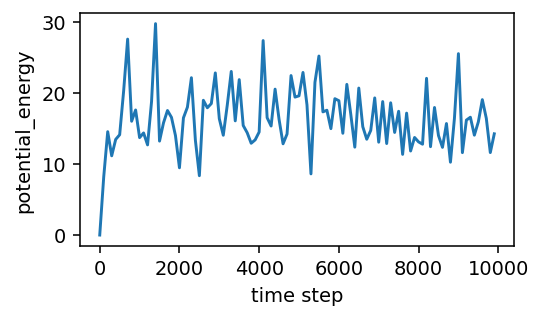

In [15]:
data = np.genfromtxt(fname='log-output.log', skip_header=True);

plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(data[:,0], data[:,1]);
plt.xlabel('time step');
plt.ylabel('potential_energy');

/Users/jenny/miniconda3/envs/planckton/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


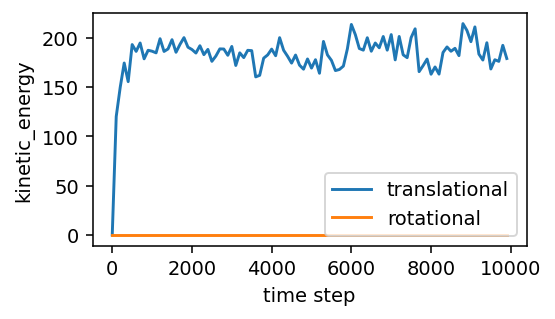

In [16]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(data[:,0], data[:,2]);
plt.plot(data[:,0], data[:,3]);
plt.xlabel('time step');
plt.ylabel('kinetic_energy');
plt.legend(['translational', 'rotational'], loc='lower right');

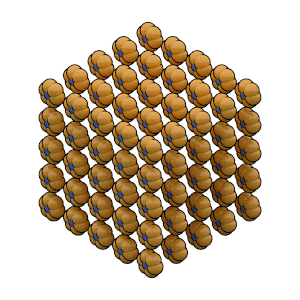

In [1]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');

In [2]:
snap = system.take_snapshot()

NameError: name 'system' is not defined

In [ ]:
def from_hoomdsnapshot(snap):
    compound = mb.Compound()
    compound.box = hoomd_to_mbuild_box(snap.box)
    for i in range(snap.particles.N):
        p = mb.Particle(
            name = snap.particles.types[snap.particles.typeid[i]],
            pos = snap.particles.position[i],
            charge = snap.particles.charge[i]
        )
        p.mass = snap.particles.mass[i]
        p.body = snap.particles.body[i]
        compound.add(p)
    return compound
    

def hoomd_to_mbuild_box(box):
    xy = box.xy
    xz = box.xz
    yz = box.yz
    alpha = np.rad2deg(np.arccos((xy * xz + yz) / (np.sqrt(1 + xy**2) * np.sqrt(1 + xz**2 + yz**2))))
    beta = np.rad2deg(np.arccos(xz / np.sqrt(1 + xz**2 + yz**2)))
    gamma = np.rad2deg(np.arccos(xy / np.sqrt(1 + xy**2)))
                                                   
    mb_box = mb.Box(
        lengths=np.array([box.Lx, box.Ly, box.Lz]),
        angles=np.array([alpha, beta, gamma])
    )
    return mb_box


In [ ]:
comp = from_hoomdsnapshot(snap)
comp.visualize(color_scheme={"_R": "blue", "A": "orange"}).show()